https://stackoverflow.com/questions/51903350/python-vs-matlab-performance-on-algorithm

First we measure the scaling of the serial implementation

_Performance enhancement 1_: use Numba within a single array

In [1]:
!hostname

f182b13dbffc


In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt

Numpy: Set how floating-point errors are handled.
    
https://docs.scipy.org/doc/numpy/reference/generated/numpy.seterr.html

In [3]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [4]:
# https://github.com/nikdon/pyEntropy
def sample_entropy(time_series, sample_length, tolerance=None):
    """Calculate and return Sample Entropy of the given time series.
    Distance between two vectors defined as Euclidean distance and can
    be changed in future releases
    Args:
        time_series: Vector or string of the sample data
        sample_length: Number of sequential points of the time series
        tolerance: Tolerance (default = 0.1...0.2 * std(time_series))
    Returns:
        Vector containing Sample Entropy (float)
    References:
        [1] http://en.wikipedia.org/wiki/Sample_Entropy
        [2] http://physionet.incor.usp.br/physiotools/sampen/
        [3] Madalena Costa, Ary Goldberger, CK Peng. Multiscale entropy analysis
            of biological signals
    """
    if tolerance is None:
        tolerance = 0.1 * np.std(time_series)

    n = len(time_series)
    prev = np.zeros(n)
    curr = np.zeros(n)
    A = np.zeros((sample_length, 1))  # number of matches for m = [1,...,template_length - 1]
    B = np.zeros((sample_length, 1))  # number of matches for m = [1,...,template_length]

    for i in range(n - 1):
        nj = n - i - 1
        ts1 = time_series[i]
        for jj in range(nj):
            j = jj + i + 1
            if abs(time_series[j] - ts1) < tolerance:  # distance between two vectors
                curr[jj] = prev[jj] + 1
                temp_ts_length = min(sample_length, curr[jj])
                for m in range(int(temp_ts_length)):
                    A[m] += 1
                    if j < n - 1:
                        B[m] += 1
            else:
                curr[jj] = 0
        for j in range(nj):
            prev[j] = curr[j]

    N = n * (n - 1) / 2
    B = np.vstack(([N], B[:sample_length - 1]))
    similarity_ratio = A / B
    se = - np.log(similarity_ratio)
    se = np.reshape(se, -1)
    return se

## function profiling

Conclusion: Most of the time is spent in "sample_entropy"

In [5]:
a = np.random.rand(1, 100)[0]

%prun -s cumtime sample_entropy(a, 4, 0.1 * np.std(a))

## line profiling

Once we know that the majority of time is spent in "Sample entropy", investigate which lines are consuming most of the CPU time

https://ipython-books.github.io/43-profiling-your-code-line-by-line-with-line_profiler/

In [6]:
!pip install line_profiler

In [7]:
%load_ext line_profiler

In [8]:
a = np.random.rand(1, 100)[0]

%lprun -f sample_entropy sample_entropy(a, 4, 0.1 * np.std(a))

## scaling of serial function

In [9]:
num_tests=3
serial_original_timing_dict={}
serial_original_reslt_dict={}
for arry_size in [100,1000,2000]:#,5000,10000]:
    reslt_ary=[]
    for test_indx in range(num_tests):
        a = np.random.rand(1, arry_size)[0]
        start_time = time.time()
        outp=sample_entropy(a, 4, 0.1 * np.std(a))
        elapsed_time = time.time() - start_time
        serial_original_reslt_dict[(arry_size,test_indx)]=outp
        print(arry_size,':',elapsed_time,'seconds')
        reslt_ary.append(elapsed_time)
    serial_original_timing_dict[arry_size]=sum(reslt_ary)/num_tests

100 : 0.02529454231262207 seconds
100 : 0.017045974731445312 seconds
100 : 0.013816356658935547 seconds
1000 : 1.1940789222717285 seconds
1000 : 1.1250905990600586 seconds
1000 : 1.1728472709655762 seconds
2000 : 5.061520099639893 seconds
2000 : 4.715592622756958 seconds
2000 : 4.607134103775024 seconds


In [10]:
serial_original_timing_dict

{100: 0.018718957901000977, 1000: 1.1640055974324544, 2000: 4.794748942057292}

In [11]:
x,y=zip(*serial_original_timing_dict.items())

In [12]:
z = np.polyfit(x, y, 2)
f = np.poly1d(z)
print(f)
x_new = np.linspace(0, 10000, 50)
y_new = f(x_new)

           2
1.241e-06 x - 9.273e-05 x + 0.01558


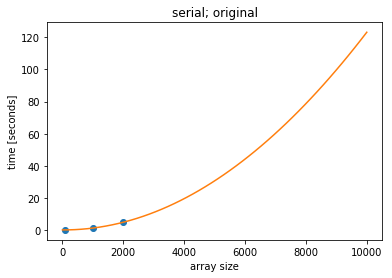

In [13]:
_=plt.plot(x,y,'o', x_new, y_new)
#plt.scatter(x,y)
plt.ylabel('time [seconds]')
plt.xlabel('array size')
plt.title('serial; original')
plt.show()

# lambda to replace for loop

as faras I understand, in order to use joblib, need to change the for loop to a generator:<BR>
https://joblib.readthedocs.io/en/latest/parallel.html#parallel<BR>
"The core idea is to write the code to be executed as a generator expression, and convert it to parallel computing"
    
According to line profiling, 30% of time is spent in a for loop that could be converted to a lambda function. Let's see what the performance enhancement is due to that change

In [14]:
# https://github.com/nikdon/pyEntropy
def sample_entropy(time_series, sample_length, tolerance=None):
    """Calculate and return Sample Entropy of the given time series.
    Distance between two vectors defined as Euclidean distance and can
    be changed in future releases
    Args:
        time_series: Vector or string of the sample data
        sample_length: Number of sequential points of the time series
        tolerance: Tolerance (default = 0.1...0.2 * std(time_series))
    Returns:
        Vector containing Sample Entropy (float)
    References:
        [1] http://en.wikipedia.org/wiki/Sample_Entropy
        [2] http://physionet.incor.usp.br/physiotools/sampen/
        [3] Madalena Costa, Ary Goldberger, CK Peng. Multiscale entropy analysis
            of biological signals
    """
    if tolerance is None:
        tolerance = 0.1 * np.std(time_series)

    n = len(time_series)
    prev = np.zeros(n)
    curr = np.zeros(n)
    A = np.zeros((sample_length, 1))  # number of matches for m = [1,...,template_length - 1]
    B = np.zeros((sample_length, 1))  # number of matches for m = [1,...,template_length]

    for i in range(n - 1):
        nj = n - i - 1
        ts1 = time_series[i]
        for jj in range(nj):
            j = jj + i + 1
            if abs(time_series[j] - ts1) < tolerance:  # distance between two vectors
                curr[jj] = prev[jj] + 1
                temp_ts_length = min(sample_length, curr[jj])
                for m in range(int(temp_ts_length)):
                    A[m] += 1
                    if j < n - 1:
                        B[m] += 1
            else:
                curr[jj] = 0
#        for j in range(nj):
#            prev[j] = curr[j]
        prev = [curr[j] for j in range(nj)]

    N = n * (n - 1) / 2
    B = np.vstack(([N], B[:sample_length - 1]))
    similarity_ratio = A / B
    se = - np.log(similarity_ratio)
    se = np.reshape(se, -1)
    return se

In [15]:
a = np.random.rand(1, 100)[0]
%lprun -f sample_entropy sample_entropy(a, 4, 0.1 * np.std(a))

In [16]:
num_tests=3
serial_lambda_timing_dict={}
serial_lambda_reslt_dict={}
for arry_size in [100,1000,2000]:#,5000,10000]:
    reslt_ary=[]
    for test_indx in range(num_tests):
        a = np.random.rand(1, arry_size)[0]
        start_time = time.time()
        outp=sample_entropy(a, 4, 0.1 * np.std(a))
        elapsed_time = time.time() - start_time
        serial_lambda_reslt_dict[(arry_size,test_indx)]=outp
        print(arry_size,':',elapsed_time,'seconds')
        reslt_ary.append(elapsed_time)
    serial_lambda_timing_dict[arry_size]=sum(reslt_ary)/num_tests

100 : 0.02243518829345703 seconds
100 : 0.012311935424804688 seconds
100 : 0.014058351516723633 seconds
1000 : 1.0680208206176758 seconds
1000 : 1.0601649284362793 seconds
1000 : 1.1553022861480713 seconds
2000 : 4.68930459022522 seconds
2000 : 4.383774042129517 seconds
2000 : 4.452362298965454 seconds


In [17]:
serial_lambda_timing_dict

{100: 0.016268491744995117, 1000: 1.0944960117340088, 2000: 4.5084803104400635}

--> Slightly faster, but not significant

In [18]:
x,y=zip(*serial_lambda_timing_dict.items())

In [19]:
z = np.polyfit(x, y, 2)
f = np.poly1d(z)
print(f)
x_new = np.linspace(0, 10000, 50)
y_new = f(x_new)

           2
1.166e-06 x - 8.489e-05 x + 0.01309


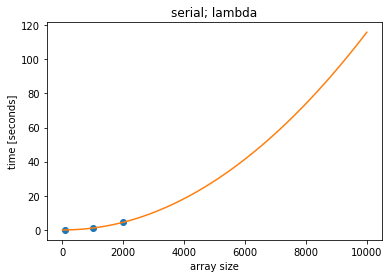

In [20]:
_=plt.plot(x,y,'o', x_new, y_new)
#plt.scatter(x,y)
plt.ylabel('time [seconds]')
plt.xlabel('array size')
plt.title('serial; lambda')
plt.show()

## compare output of original and lambda-based

--> I don't know how to interpret the outputs, so I don't know whether the comparisons are acceptable

In [21]:
serial_original_reslt_dict

{(100, 0): array([ 2.94262245,  2.70412092,  2.14006616,         inf]),
 (100, 1): array([ 2.91615588,  3.36345705,         inf,         nan]),
 (100, 2): array([ 2.85115104,  2.53657866,  2.35137526,         inf]),
 (1000, 0): array([ 2.85824475,  2.88298805,  2.98330975,  2.60268969]),
 (1000, 1): array([ 2.88706193,  2.88638533,  2.83385955,  2.43141796]),
 (1000, 2): array([ 2.87060446,  2.89040717,  2.86700473,  2.40919483]),
 (2000, 0): array([ 2.87167029,  2.88182748,  2.79721815,  3.12262403]),
 (2000, 1): array([ 2.87251022,  2.87674864,  2.86440839,  3.11905549]),
 (2000, 2): array([ 2.86771003,  2.86588657,  2.80405765,  3.19611884])}

In [22]:
serial_lambda_reslt_dict

{(100, 0): array([ 2.85816862,  2.91235066,  2.56494936,         nan]),
 (100, 1): array([ 2.87952174,  2.76890548,  2.14006616,         inf]),
 (100, 2): array([ 2.97375337,  2.87033101,  2.56494936,         inf]),
 (1000, 0): array([ 2.86598682,  2.8227681 ,  2.81380668,  3.51650823]),
 (1000, 1): array([ 2.85153227,  2.81931872,  2.78372927,  2.87167962]),
 (1000, 2): array([ 2.87919125,  2.85090654,  2.99016123,  2.74727091]),
 (2000, 0): array([ 2.85507029,  2.8678815 ,  2.90022709,  3.11073367]),
 (2000, 1): array([ 2.86305542,  2.87291682,  2.94164871,  3.11794991]),
 (2000, 2): array([ 2.88019065,  2.88939067,  2.89616888,  3.35573501])}

# fine-grain concurrency: Numba
### Numba = JIT compiler that translates Python and NumPy code into machine code

https://numba.pydata.org/numba-doc/dev/user/performance-tips.html

https://numba.pydata.org/numba-doc/latest/user/parallel.html
https://numba.pydata.org/numba-doc/latest/user/jit.html#parallel-jit-option

In [23]:
import numba as nb

In [24]:
print(nb.__version__)

0.38.1


In [25]:
# https://numba.pydata.org/numba-doc/dev/reference/envvars.html#numba-envvars
import os
os.environ["NUMBA_WARNINGS"] = "1"

I recommend playing around with the various arguments to figure out which combination is best

In [26]:
@nb.jit(fastmath=True,error_model='numpy',parallel=True,nopython=True)
def sample_entropy(time_series, sample_length, tolerance=None):
    """Calculate and return Sample Entropy of the given time series.
    Distance between two vectors defined as Euclidean distance and can
    be changed in future releases
    Args:
        time_series: Vector or string of the sample data
        sample_length: Number of sequential points of the time series
        tolerance: Tolerance (default = 0.1...0.2 * std(time_series))
    Returns:
        Vector containing Sample Entropy (float)
    References:
        [1] http://en.wikipedia.org/wiki/Sample_Entropy
        [2] http://physionet.incor.usp.br/physiotools/sampen/
        [3] Madalena Costa, Ary Goldberger, CK Peng. Multiscale entropy analysis
            of biological signals
    """
    if tolerance is None:
        tolerance = 0.1 * np.std(time_series)

    n = len(time_series)
    prev = np.zeros(n)
    curr = np.zeros(n)
    A = np.zeros((sample_length))  # number of matches for m = [1,...,template_length - 1]
    B = np.zeros((sample_length))  # number of matches for m = [1,...,template_length]

    for i in range(n - 1):
        nj = n - i - 1
        ts1 = time_series[i]
        for jj in range(nj):
            j = jj + i + 1
            if abs(time_series[j] - ts1) < tolerance:  # distance between two vectors
                curr[jj] = prev[jj] + 1
                temp_ts_length = min(sample_length, curr[jj])
                for m in range(int(temp_ts_length)):
                    A[m] += 1
                    if j < n - 1:
                        B[m] += 1
            else:
                curr[jj] = 0
        for j in range(nj):
            prev[j] = curr[j]

    N = n * (n - 1) // 2

    B2=np.empty(sample_length)
    B2[0]=N
    B2[1:]=B[:sample_length - 1]
    similarity_ratio = A / B2
    se = - np.log(similarity_ratio)
    return se

In [27]:
num_tests=3
numba_reslt_dict={}
for arry_size in [100,1000,5000,10000,50000,100000]:
    reslt_ary=[]
    for test_indx in range(num_tests):
        a = np.random.rand(1, arry_size)[0]
        start_time = time.time()
        sample_entropy(a, 4, 0.1 * np.std(a))
        elapsed_time = time.time() - start_time
        print(arry_size,':',elapsed_time,'seconds')
        reslt_ary.append(elapsed_time)
    numba_reslt_dict[arry_size]=sum(reslt_ary)/num_tests

100 : 2.6560988426208496 seconds
100 : 0.0010023117065429688 seconds
100 : 0.0008499622344970703 seconds
1000 : 0.002414703369140625 seconds
1000 : 0.0024509429931640625 seconds
1000 : 0.0024175643920898438 seconds
5000 : 0.040383100509643555 seconds
5000 : 0.04054617881774902 seconds
5000 : 0.040556907653808594 seconds
10000 : 0.167405366897583 seconds
10000 : 0.15687775611877441 seconds
10000 : 0.16631364822387695 seconds
50000 : 4.375365257263184 seconds
50000 : 4.418511152267456 seconds
50000 : 4.461950302124023 seconds
100000 : 17.915629863739014 seconds
100000 : 17.54906463623047 seconds
100000 : 17.499608993530273 seconds


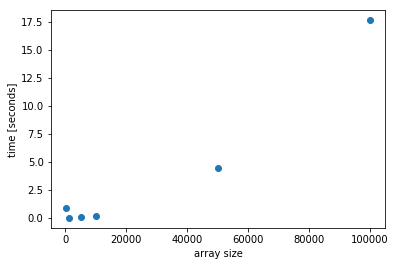

In [28]:
x,y=zip(*numba_reslt_dict.items())
plt.scatter(x,y)
plt.ylabel('time [seconds]')
plt.xlabel('array size')
plt.show()

In [29]:
z = np.polyfit(x, y, 2)

In [30]:
f = np.poly1d(z)
print(f)

           2
1.874e-09 x - 1.348e-05 x + 0.2909


In [31]:
x_new = np.linspace(0, 100000, 50)
y_new = f(x_new)

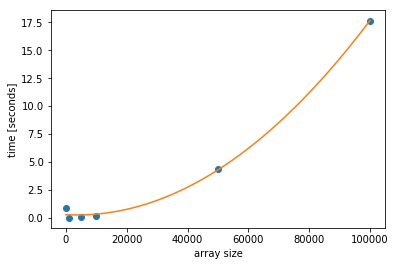

In [32]:
_=plt.plot(x,y,'o', x_new, y_new)
_=plt.ylabel('time [seconds]')
_=plt.xlabel('array size')

In [33]:
2*(2.092e-09)

4.184e-09

In [34]:
x=18000000 # array size
print((2.092e-09*x*x) - (5.401e-06*x) + 0.01703,'seconds')

677710.7990299999 seconds


677710.7990299999 seconds = 8 days

In [35]:
x=30000 # array size
print((2.092e-09*x*x) - (5.401e-06*x) + 0.01703,'seconds')

1.7377999999999998 seconds
